<a href="https://colab.research.google.com/github/justjstine/CCADMACL_EXERCISES_COM232/blob/main/Exercise3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3B

In this exercise, you will explore how the DBSCAN clustering algorithm identifies dense groups and outliers in the Pokémon statistics dataset. You will analyze the dataset, scale features, determine DBSCAN parameters, run DBSCAN, and interpret the clustering results.

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics


In [2]:
# Download latest version
path = kagglehub.dataset_download("abcsds/pokemon")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'pokemon' dataset.
Path to dataset files: /kaggle/input/pokemon


In [3]:
if os.path.isdir(path):
  print(True)

contents = os.listdir(path)
contents

mydataset = path + "/" + contents[0]
mydataset


df = pd.read_csv(mydataset)

True


## 1. Load the Dataset (8 pts)

Load the Pokémon dataset into a pandas DataFrame.

Show the first five rows (3 pts)

In [4]:
df.head(5)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False



How many Pokémon are in the dataset? (2 pts)


In [7]:
df.shape

(800, 13)


List all columns available (3 pts)

In [8]:
df.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

## 2: Select Features & Clean the Data (8 pts)

Select the numeric features needed for clustering (HP, Attack, Defense, Sp. Atk, Sp. Def, Speed). (3 pts)

In [9]:
df1 = df[["Speed", "Attack", "Defense"]]
df1


,Speed,Attack,Defense
0,45,49,49
1,60,62,63
2,80,82,83
3,80,100,123
4,65,52,43
...,...,...,...
795,50,100,150
796,110,160,110
797,70,110,60
798,80,160,60


Are there any missing values? (2 pts)

In [11]:
df1.isnull().sum()

,0
Speed,0
Attack,0
Defense,0


If missing values exist, describe how you handled them (3 pts)

In [ ]:
# put your answer here

In [12]:
fig = px.scatter_3d(df, x='Speed', y='Attack', z='Defense',
                    title='3D Scatterplot - Pokemon')
fig.show()

# 3. Scale the Features (10 pts)

Apply StandardScaler to the selected features.

Show the transformed feature sample (e.g., first 5 rows) (10 pts)


In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df1)

scaled_df = pd.DataFrame(scaled_features, columns=df1.columns)

print(scaled_df.head(5))

      Speed    Attack   Defense
0 -0.801503 -0.924906 -0.797154
1 -0.285015 -0.524130 -0.347917
2  0.403635  0.092448  0.293849
3  0.403635  0.647369  1.577381
4 -0.112853 -0.832419 -0.989683


## 4. Determine a Suitable eps Value (10 pts)

Using k = 4:
Compute the distance to the 4th nearest neighbor for each Pokémon (6 pts)

In [14]:
nn = NearestNeighbors(n_neighbors=4).fit(scaled_df)
distances, indices = nn.kneighbors(scaled_df)

What is your chosen eps based on the "elbow"? (2 pts)

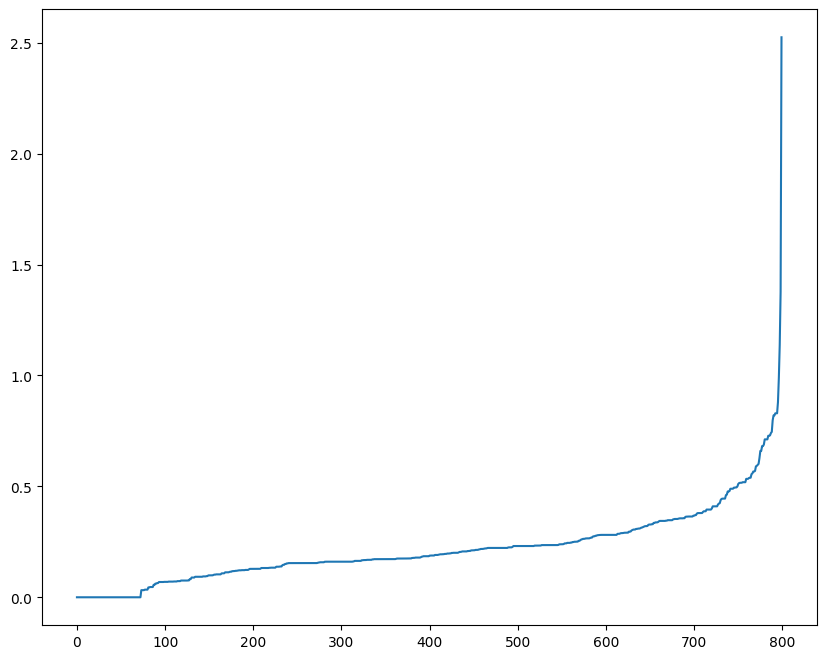

In [15]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)


In [24]:
min_samples = range(3,5)
epsilon = np.arange(0.5, 1.0, 0.1)
epsilon

array([0.5, 0.6, 0.7, 0.8, 0.9])

In [25]:
output = []

for ms in min_samples:
    for ep in epsilon:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(scaled_df).labels_
        score = metrics.silhouette_score(scaled_df, labels)
        output.append((ms, ep, score))

In [26]:
min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

min_samples: 3
eps: 0.8999999999999999


One-sentence explanation of your reasoning (2 pts)

Based on the elbow graph and the nearest neighbot 4, it shows that around 0.6 - 0.8 eps is the "optimal eps" since this is where the curve stops ascending.

## 5. Run DBSCAN (10 points)

Run DBSCAN using your chosen eps and min_samples


In [19]:
ep = eps
dbscan = DBSCAN(eps = ep, min_samples=min_samples).fit(scaled_df)
labels = dbscan.labels_

# Number of clusters in labels
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Number of noise
n_noise_ = list(labels).count(-1)

silhouette_score = metrics.silhouette_score(scaled_df, labels)

How many clusters did DBSCAN find? (4 pts)

In [20]:
print("Estimated number of clusters: %d" % n_clusters_)

Estimated number of clusters: 1


How many Pokémon were labeled as noise? (4 pts)

In [21]:
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of noise points: 6


Show the unique labels output by DBSCAN (2 pts)

In [22]:
scaled_df_with_labels = scaled_df.copy()
scaled_df_with_labels['Cluster'] = labels


fig = px.scatter_3d(scaled_df_with_labels, x='Speed', y='Attack', z='Defense',
                    color='Cluster', title='DBSCAN Clusters (3D Scatterplot)')
fig.show()

## 6. Attach Cluster Labels to the Original Dataset (7 points)

Add the cluster labels back to the original DataFrame (3 pts)

In [23]:
df['Cluster'] = labels

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Cluster
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,0


Show the first 10 rows including the cluster label (4 pts)

In [27]:
df.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Cluster
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,0
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,0
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False,0
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False,0
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False,0
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False,0


## 7. Explore the Clusters (12 points)

For each cluster:


How many Pokémon does it contain? (4 pts)

In [31]:
df['Cluster'].value_counts()

,count
Cluster,
0,794
-1,6


What are the average Attack, Defense, and Speed? (4 pts)


In [36]:
df.groupby('Cluster')[['Attack', 'Defense', 'Speed']].mean()

,Attack,Defense,Speed
Cluster,,,
-1,103.333333,160.000000,84.166667
0,78.817380,73.191436,68.157431


Compare the clusters: What differences do you notice? (4 pts)

Based on the single cluster that was formed, means that most of the pokemon share similar stats specifically Attack, Speed, and Defense.

## 8. Identify Outliers (10 points)

List all Pokémon labeled as noise (cluster = -1) (4 pts)

In [37]:
df[df['Cluster'] == -1]

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Cluster
224,208,SteelixMega Steelix,Steel,Ground,610,75,125,230,55,95,30,2,False,-1
230,213,Shuckle,Bug,Rock,505,20,10,230,10,230,5,2,False,-1
333,306,AggronMega Aggron,Steel,NaN,630,70,140,230,60,80,50,3,False,-1
429,386,DeoxysAttack Forme,Psychic,NaN,600,50,180,20,180,20,150,3,True,-1
430,386,DeoxysDefense Forme,Psychic,NaN,600,50,70,160,70,160,90,3,True,-1
431,386,DeoxysSpeed Forme,Psychic,NaN,600,50,95,90,95,90,180,3,True,-1


Are many of them legendary? (3 pts)

Half out of the 6 labeled as outliers are legendary, and the rest are considered as non-legendary Pokemons.

Explain why DBSCAN might classify them as outliers (3 pts)

They might be classified as outliers due to their more "powerful" or increased stats than other averaged stats of Pokemon, meaning there is a significant difference between a legendary Pokemon and to non-legendary Pokemons.

## 9. Interpret the Clustering Results (25 points)
Write a short interpretation (4–6 sentences).
Discuss:


What types of Pokémon grouped together (5 pts)

Since the only features used are Attack, Speed, and Defense, it only formed 1 cluster. This cluster can be considered as the "raw stats" or basic stats of Pokemon because of the said features that was used during the use of DBSCAN.


Whether the clusters make intuitive sense (10 pts)

Yes. It does make sense in a certain degree since the features used were limited with just basic. Attack, Defense, and Speed represent only the “raw combat stats of each Pokemon, many Pokémon end up having very similar values of each Pokemon, without the consideration of their Special Attacks and Special Defense, This explains why almost the entire dataset falls into a single cluster, most Pokémon share comparable stats. it naturally forms only one general group.




What the noise points reveal about DBSCAN (5 pts)


The presence of 6 noise points shows how DBSCAN identifies Pokémon whose stats significantly from the average stats. Since half of these outliers are legendaries, DBSCAN reveals to detect individuals with high or unique stats. The noise points reflect DBSCAN’s sensitivity to Pokémon that are either too strong, too fast, or too defensively which fall outside the main cluster. This indicates that DBSCAN flags exceptional stat profiles even when most data points look similar.


What stat patterns you discovered (5 pts)

A clear pattern observed is that most Pokémon share balanced scaled Attack, Defense, and Speed values, leading to one large, dense cluster. This suggests that the majority of Pokémon are designed around similar stat ranges rather than having "overpowered stats". The outliers, on the other hand, tend to have very high values in at least one of the features, especially legendaries, which often have stronger or more stat spreads. Overall, the "raw combat features" shows a balance stats throughout the Pokemons.